In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [10]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_zh_preprocess/2"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/3"
hub.load(tfhub_handle_preprocess)
hub.load(tfhub_handle_encoder)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f9924750bb0>

In [3]:
batch_size = 16
bad_dataset = tf.data.experimental.make_csv_dataset(
    'training_sample_bad.csv',
    batch_size=batch_size, # Artificially small to make examples easier to show.
    column_defaults=[tf.string,tf.string,tf.float32],
    label_name='judge',
    num_epochs=1,
    ignore_errors=True,)
good_dataset = tf.data.experimental.make_csv_dataset(
    'training_sample_good.csv',
    batch_size=batch_size, # Artificially small to make examples easier to show.
    column_defaults=[tf.string,tf.string,tf.float32],
    label_name='judge',
    num_epochs=10,
    ignore_errors=True,)
all_dataset = bad_dataset.concatenate(good_dataset).shuffle(100000, reshuffle_each_iteration=True)

In [4]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places.
    @param dataset: the input dataset to split.
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1.
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

In [ ]:
for batch, label in all_dataset.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value.numpy()[0].decode()}")
  print()
  print(f"{'label':20s}: {label.numpy()[0]}")

In [5]:
train_ds, val_ds = split_dataset(all_dataset, 0.2)

# 自定义模型

In [6]:
con_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='con_input')
cause_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='cause_input')
preprocessor = hub.load(tfhub_handle_preprocess)
tokenize = hub.KerasLayer(preprocessor.tokenize, name='tokenize')
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=512), name='bert_pack_inputs')
tokenized_inputs = [tokenize(segment) for segment in [con_input,cause_input]]
encoder_inputs = bert_pack_inputs(tokenized_inputs)
encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')
pooled_output = encoder(encoder_inputs)['pooled_output']
dropout = tf.keras.layers.Dropout(0.1, name='dropout')(pooled_output)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(dropout)
logregress_model = tf.keras.Model({'con':con_input, 'cause':cause_input}, output)

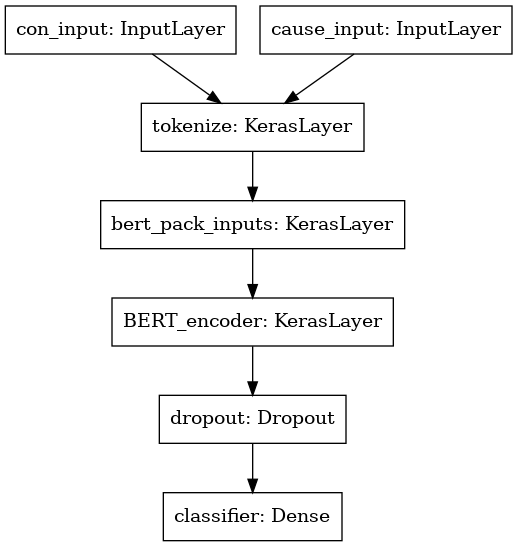

In [7]:
tf.keras.utils.plot_model(logregress_model)

In [8]:
logregress_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
con_input (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
cause_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
tokenize (KerasLayer)           (None, None, None)   0           con_input[0][0]                  
                                                                 cause_input[0][0]                
__________________________________________________________________________________________________
bert_pack_inputs (KerasLayer)   {'input_mask': (None 0           tokenize[0][0]               

In [9]:
encoder.trainable = True

# 加载Savedmodel
> 目前 tf2.3 2.4有bug，需要拷贝 assert 到 tmp 目录
> 
> 执行 `cp -r ./seq_match_bert/assets/ /tmp/tfhub_modules/ac88b3f8006a88375d21bd4422db821cabe4b7c3`

In [13]:
logregress_model = tf.keras.models.load_model('./seq_match_bert')

# 优化器 损失函数 & 指标

In [19]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.metrics.BinaryAccuracy(),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

In [15]:
from official.nlp import optimization  # to create AdamW optmizer

In [16]:
epochs = 5
steps_per_epoch = 0
for data in train_ds:
    steps_per_epoch+=1
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [20]:
logregress_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# Training

In [21]:
logregress_model.fit(x=train_ds,validation_data=val_ds,epochs=5)

Epoch 1/5
6123/6123 [==============================] - 3078s 502ms/step - loss: 0.0884 - binary_accuracy: 0.9790 - precision: 0.9569 - recall: 0.9907 - val_loss: 0.0475 - val_binary_accuracy: 0.9894 - val_precision: 0.9774 - val_recall: 0.9958
Epoch 2/5
  54/6123 [..............................] - ETA: 46:28 - loss: 0.0823 - binary_accuracy: 0.9821 - precision: 0.9526 - recall: 0.9931

KeyboardInterrupt: 

# Evaluation

In [ ]:
logregress_model.evaluate(val_ds)

In [133]:
x1 = [
    ''
]
x2 = ['关于原告各项合理损失数额的认定']
cons = [{
    'con':'本次交通事故民事赔偿责任如何承担',
    'line':25,
},
{
    'con':'原告请求赔偿项目及数额应如何确定',
    'line':25,
}]

with open('/home/cao/Programming/baker/data/raw/case2.txt') as f:
    lines = f.readlines()
    start = 0
    for con in cons:
        start = start if start>con['line'] else con['line']
        max = 0.0
        mline = 0
        for num,line in enumerate(lines):
            if num>start:
                original_results = logregress_model([tf.constant([con['con']]),tf.constant([line])])
                if num-start<3 and tf.math.greater(original_results,0.5):
                    max=original_results
                    mline=num
                    break
                elif tf.math.greater(original_results,max):
                    max=original_results
                    mline=num
        start = mline
        print(str(mline)+': ',max,lines[mline])

26:  tf.Tensor([[0.9116733]], shape=(1, 1), dtype=float32)         关于本次交通事故民事赔偿责任应如何承担的问题，本院认为：被告张旭驾驶“鲁HM355Q”轻型非载货专项作业车与受害人魏士玉驾驶的摩托车发生碰撞，造成魏士玉死亡的交通事故，业经邹城市公安局交通警察大队作出交通事故责任认定书，认定受害人魏士玉与被告张旭承担事故的同等责任。原、被告对事故责任认定书均无异议，本院予以确认。在本次交通事故中，魏士玉经抢救无效死亡，原告魏呈坤、魏王氏、王其秀、魏广安、魏丽丽、魏广营系受害人魏士玉的近亲属，具有要求被告赔偿各项经济损失的权利。被告平安财险济宁支公司作为“鲁HM355Q”轻型非载货专项作业车的保险人，亦无免赔情形，依法应当在被保险机动车交强险各分项限额范围内对原告损失先行赔偿，不足部分再按照商业保险合同约定和各自过错责任比例进行赔偿，仍有不足部分再按照《侵权责任法》和《交通事故安全法》的相关规定由侵权责任人赔偿。在本次事故中，受害人魏士玉与被告张旭承担事故同等责任，双方均有过错，应根据双方在本次事故中的过错程度，对超出交通事故强制保险责任限额范围以外的损失，由被告张旭承担50%民事赔偿责任。根据相关法律规定，机动车所有人与使用人不是同一人时，发生交通事故后属于该机动车一方责任的，由保险公司在机动车强制保险责任限额范围内予以赔偿。不足部分，由机动车使用人承担赔偿责任;机动车所有人对损害的发生有过错的，承担相应的赔偿责任。因张旭与被告济宁绿源食品有限公司未到庭参加诉讼，原告未举证证明张旭与被告济宁绿源食品有限公司之间的法律关系，应由侵权人张旭承担民事赔偿责任。被告济宁绿源食品有限公司虽系登记车主，但原告未举证证明在交通事故中有过错，不应承担民事赔偿责任。

27:  tf.Tensor([[0.9849022]], shape=(1, 1), dtype=float32)         关于原告请求赔偿项目及其数额应如何确定的问题，本院认为：1.医疗费：原告向本院提交邹城市人民医院出具的门诊收费票据18张，并以门诊病历、门诊收费清单相佐证，旨在证明抢救魏士玉支出医疗费1，163.08元。经质证，被告平安财险济宁支公司对原告提供证据的真实性无异议。本院认为，被告对原告提供证据的真实性没异议，本院予以认定。根

# Saving

In [ ]:
logregress_model.save('seq_match_bert',overwrite=False,include_optimizer=False)

# Serving

In [151]:
def seq_match(con,cause):
    model = logregress_model.signatures['serving_default']
    return model(con_input=tf.constant(con),
                cause_input=tf.constant(cause))['classifier']


In [152]:
cons = [{
    'con':'本次交通事故民事赔偿责任如何承担',
    'line':25,
},
{
    'con':'原告请求赔偿项目及数额应如何确定',
    'line':25,
}]

with open('/home/cao/Programming/baker/data/raw/case2.txt') as f:
    lines = f.readlines()
    start = 0
    for con in cons:
        start = start if start>con['line'] else con['line']
        max = 0.0
        mline = 0
        for num,line in enumerate(lines):
            if num>start:
                original_results = seq_match(con['con'],line)
                if num-start<3 and tf.math.greater(original_results,0.5):
                    max=original_results
                    mline=num
                    break
                elif tf.math.greater(original_results,max):
                    max=original_results
                    mline=num
        start = mline
        print(str(mline)+': ',max,lines[mline])

26:  tf.Tensor([[0.98577327]], shape=(1, 1), dtype=float32)         关于本次交通事故民事赔偿责任应如何承担的问题，本院认为：被告张旭驾驶“鲁HM355Q”轻型非载货专项作业车与受害人魏士玉驾驶的摩托车发生碰撞，造成魏士玉死亡的交通事故，业经邹城市公安局交通警察大队作出交通事故责任认定书，认定受害人魏士玉与被告张旭承担事故的同等责任。原、被告对事故责任认定书均无异议，本院予以确认。在本次交通事故中，魏士玉经抢救无效死亡，原告魏呈坤、魏王氏、王其秀、魏广安、魏丽丽、魏广营系受害人魏士玉的近亲属，具有要求被告赔偿各项经济损失的权利。被告平安财险济宁支公司作为“鲁HM355Q”轻型非载货专项作业车的保险人，亦无免赔情形，依法应当在被保险机动车交强险各分项限额范围内对原告损失先行赔偿，不足部分再按照商业保险合同约定和各自过错责任比例进行赔偿，仍有不足部分再按照《侵权责任法》和《交通事故安全法》的相关规定由侵权责任人赔偿。在本次事故中，受害人魏士玉与被告张旭承担事故同等责任，双方均有过错，应根据双方在本次事故中的过错程度，对超出交通事故强制保险责任限额范围以外的损失，由被告张旭承担50%民事赔偿责任。根据相关法律规定，机动车所有人与使用人不是同一人时，发生交通事故后属于该机动车一方责任的，由保险公司在机动车强制保险责任限额范围内予以赔偿。不足部分，由机动车使用人承担赔偿责任;机动车所有人对损害的发生有过错的，承担相应的赔偿责任。因张旭与被告济宁绿源食品有限公司未到庭参加诉讼，原告未举证证明张旭与被告济宁绿源食品有限公司之间的法律关系，应由侵权人张旭承担民事赔偿责任。被告济宁绿源食品有限公司虽系登记车主，但原告未举证证明在交通事故中有过错，不应承担民事赔偿责任。

27:  tf.Tensor([[0.98574615]], shape=(1, 1), dtype=float32)         关于原告请求赔偿项目及其数额应如何确定的问题，本院认为：1.医疗费：原告向本院提交邹城市人民医院出具的门诊收费票据18张，并以门诊病历、门诊收费清单相佐证，旨在证明抢救魏士玉支出医疗费1，163.08元。经质证，被告平安财险济宁支公司对原告提供证据的真实性无异议。本院认为，被告对原告提供证据的真实性没异议，本院予以认定